In [ ]:
import sys
sys.path.append('../03-code/')
import pandas as pd

#from model_training_helper import *
from config import PROJECT_ROOT_DIRECTORY, COLUMNS_DICT

from rdkit.Chem import Descriptors

from rdkit import Chem
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [2]:
pubchem_existence_csv = PROJECT_ROOT_DIRECTORY + '01-rawdata/15-pubchem-existence/existence_generation_6.csv'   
pubchem_existence_dataframe = pd.read_csv(pubchem_existence_csv)
pubchem_existence_dataframe['PubChem_existence'] = pubchem_existence_dataframe['cid'].notna()

In [24]:
for idx, row in pubchem_existence_dataframe.iterrows():

    neutral_mol = Chem.MolFromSmiles(row['smiles_neutral'])

    logP = Descriptors.MolLogP(neutral_mol)

    sascore_value = sascorer.calculateScore(neutral_mol)

    pubchem_existence_dataframe.at[idx, 'LogP'] = logP
    pubchem_existence_dataframe.at[idx, 'SAScore'] = sascore_value

In [25]:
pubchem_existence_dataframe.to_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/15-practicality-processability/practicality_generation_6.csv', index=False)

In [ ]:
combined_practicality_dataframe = pd.DataFrame()
for i in range(0,5):
    practicality_csv = PROJECT_ROOT_DIRECTORY + '01-rawdata/15-practicality-processability/practicality_generation_' + str(i) + '.csv'   
    practicality_dataframe = pd.read_csv(practicality_csv)[['smiles_canonical', 'PubChem_existence', 'LogP', 'SAScore']]
    practicality_dataframe['generation'] = i
    combined_practicality_dataframe = pd.concat([combined_practicality_dataframe, practicality_dataframe], ignore_index=True)


In [ ]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import Draw
from rdkit.Chem import BRICS
import rdkit
print(rdkit.__version__)

2023.09.4


### SA score

In [3]:
def calculate_sascore(smiles: str) -> float:
    """
    Calculate the Synthetic Accessibility Score (SAScore) for a given SMILES string.

    Parameters:
    smiles (str): The SMILES representation of the molecule.

    Returns:
    float: The SAScore of the molecule.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    return sascorer.calculateScore(mol)

In [4]:
print(calculate_sascore('[NH]c1cccc2cc3cc4cc5cccc([NH])c5cc4cc3cc12'))  # Example usage

2.938333291633592


In [5]:
organic_pubchem_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY+'02-metadata/06-csv-files/10-pubchem-existence.csv', index_col='identifier')

In [6]:
organic_pubchem_dataframe

,PubChem_existence,smiles_neutral,iupac_name,cid
identifier,,,,
1,False,NCc1cc2sc(CN)cc2s1,NaN,NaN
2,False,NCc1cc2sc(N)cc2s1,NaN,NaN
3,True,Nc1cc2sc(N)cc2s1,"thieno[3,2-b]thiophene-2,5-diamine",69289713.0
4,True,NCc1ccc(CN)s1,[5-(aminomethyl)thiophen-2-yl]methanamine,12979461.0
5,True,NCc1ccc(CN)o1,[5-(aminomethyl)furan-2-yl]methanamine,13561170.0
...,...,...,...,...
40536,False,Cc1cc2c(F)c(C(C)N)sc2cc1CN,NaN,NaN
40537,False,Cc1cc(CN)cc2sc(C(C)N)c(F)c12,NaN,NaN
40538,False,Cc1c(CN)cc2sc(CN)c(F)c2c1C,NaN,NaN


In [11]:
for idx, row in organic_pubchem_dataframe.iterrows():
    sascorer_value = calculate_sascore(row['smiles_neutral'])
    organic_pubchem_dataframe.at[idx, 'sascorer'] = sascorer_value

    n_pieces = calculate_pieces(row['smiles_neutral'])
    organic_pubchem_dataframe.at[idx, 'n_brics_pieces'] = n_pieces

In [47]:
for idx, row in organic_pubchem_dataframe.iterrows():
    mol = Chem.MolFromSmiles(row['smiles_neutral'])
    pieces = BRICS.BRICSDecompose(mol)


    # calculate the sascore of each piece and return the highest one
    piece_sascores = [sascorer.calculateScore(Chem.MolFromSmiles(p)) for p in pieces]
    max_piece_sascore = max(piece_sascores) if piece_sascores else None
    organic_pubchem_dataframe.at[idx, 'max_piece_sascore'] = max_piece_sascore


In [48]:
organic_pubchem_dataframe

,PubChem_existence,smiles_neutral,iupac_name,cid,sascorer,n_brics_pieces,max_piece_sascore
identifier,,,,,,,
1,False,NCc1cc2sc(CN)cc2s1,NaN,NaN,3.017987,2.0,5.494065
2,False,NCc1cc2sc(N)cc2s1,NaN,NaN,3.193146,2.0,5.494065
3,True,Nc1cc2sc(N)cc2s1,"thieno[3,2-b]thiophene-2,5-diamine",69289713.0,3.411628,1.0,3.411628
4,True,NCc1ccc(CN)s1,[5-(aminomethyl)thiophen-2-yl]methanamine,12979461.0,2.587410,2.0,5.872313
5,True,NCc1ccc(CN)o1,[5-(aminomethyl)furan-2-yl]methanamine,13561170.0,2.519857,2.0,5.873939
...,...,...,...,...,...,...,...
40536,False,Cc1cc2c(F)c(C(C)N)sc2cc1CN,NaN,NaN,3.411097,3.0,5.494065
40537,False,Cc1cc(CN)cc2sc(C(C)N)c(F)c12,NaN,NaN,3.358450,3.0,5.494065
40538,False,Cc1c(CN)cc2sc(CN)c(F)c2c1C,NaN,NaN,3.139204,2.0,5.494065


<Axes: xlabel='sascorer', ylabel='Count'>

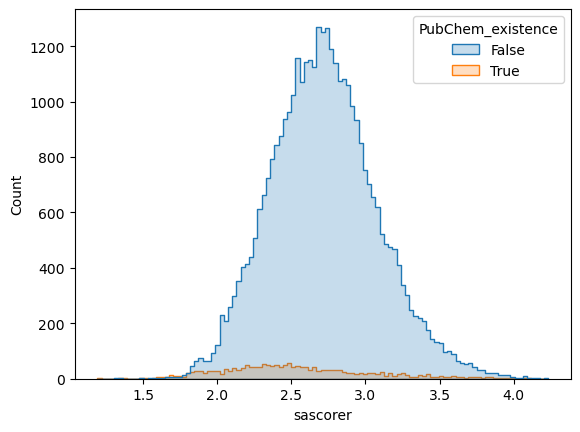

In [17]:
import seaborn as sns

# plot SAScore values against Pubchem existence
# hue order draws True on top of False
sns.histplot(x='sascorer', hue='PubChem_existence', data=organic_pubchem_dataframe.sort_values('PubChem_existence'), hue_order=[False, True],
             element='step')


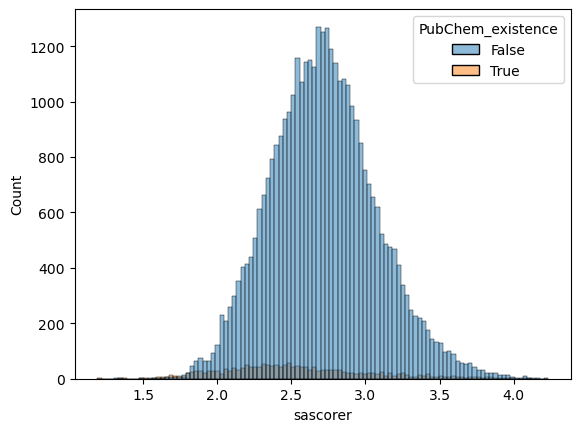

In [19]:
import seaborn as sns

# plot SAScore values against Pubchem existence
# hue order True on top of False
fig = sns.histplot(x='sascorer', hue='PubChem_existence', data=organic_pubchem_dataframe, hue_order=[False, True])
# save figure as svg

import matplotlib.pyplot as plt
fig.figure.savefig('../rawfigures/10-sascorer-pubchem-existence.svg')


<Axes: xlabel='n_brics_pieces', ylabel='Count'>

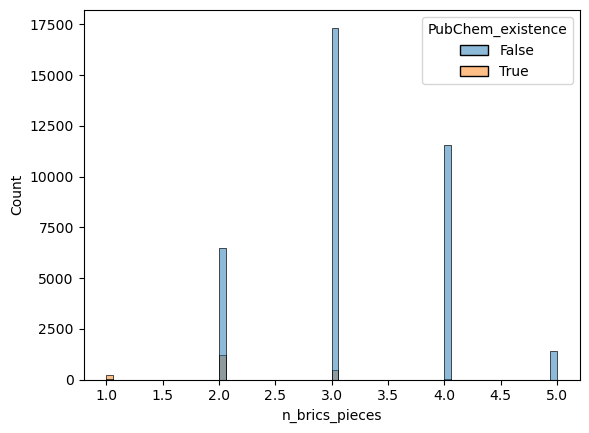

In [19]:
sns.histplot(x='n_brics_pieces', hue='PubChem_existence', data=organic_pubchem_dataframe)

<Axes: xlabel='sascorer', ylabel='max_piece_sascore'>

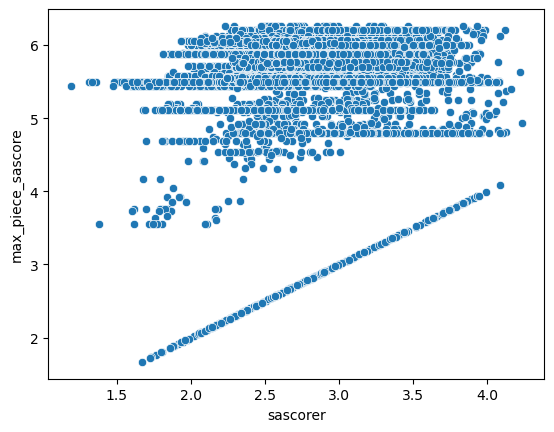

In [51]:
sns.scatterplot(x='sascorer', y='max_piece_sascore', data=organic_pubchem_dataframe)